### Análisis Exploratorio 


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [36]:
sns.set_style("whitegrid")
train_df = pd.read_csv("train.csv")

In [37]:
print("Información general del dataset:")
train_df.info()

print("\nResumen estadístico:")
print(train_df.describe())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460

In [38]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nValores nulos por columna:")
print(missing_values)


Valores nulos por columna:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [39]:
# Llenar valores nulos en variables categóricas con "None"
categorical_features = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                        "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
for col in categorical_features:
    train_df[col] = train_df[col].fillna("None")
    
# Llenar valores nulos en variables numéricas con la mediana
numerical_features = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]
for col in numerical_features:
    train_df[col] = train_df[col].fillna(train_df[col].median())

In [40]:
# Aplicar logaritmo al precio de venta para normalizar
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Convertir variables categóricas en numéricas con Label Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

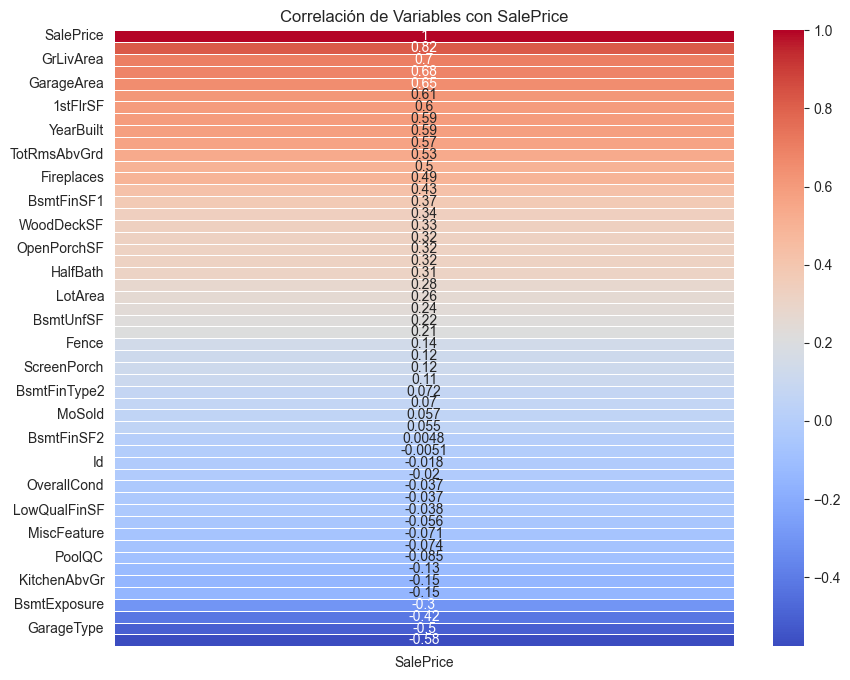

In [41]:
# --- 4. ANÁLISIS DE CORRELACIÓN ---
plt.figure(figsize=(10, 8))
corr_matrix = train_df.corr(numeric_only=True)
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False), 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlación de Variables con SalePrice")
plt.show()

In [42]:
correlation_threshold = 0.5
strong_corr_vars = corr_matrix["SalePrice"].abs().sort_values(ascending=False)
strong_corr_vars = strong_corr_vars[strong_corr_vars > correlation_threshold]
print("Variables con mayor correlación con SalePrice:")
print(strong_corr_vars)

Variables con mayor correlación con SalePrice:
SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
BsmtQual        0.576969
YearRemodAdd    0.565608
TotRmsAbvGrd    0.534422
GarageType      0.503129
Name: SalePrice, dtype: float64


In [43]:
# --- 5. DIVISIÓN DEL DATASET ---
X = train_df.drop(columns=["SalePrice", "Id"])
y = train_df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de los conjuntos de datos:")
print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")



Tamaño de los conjuntos de datos:
Entrenamiento: (1168, 79), Prueba: (292, 79)


In [44]:
categorical_features = X_train.select_dtypes(include=['object']).columns

column_transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='passthrough' 
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

print("Preprocesamiento completado")

Preprocesamiento completado
